Kiersten Wener
Eli Chesnut 

In [2]:
# imports
import pandas as pd
import numpy as np
import os

In [3]:
import kagglehub
path = kagglehub.dataset_download("fatemehmehrparvar/obesity-levels")
csv_file_path = os.path.join(path, "ObesityDataSet_raw_and_data_sinthetic.csv") 
print("Path to dataset files:", path)

/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/elichesnut/.cache/kagglehub/datasets/fatemehmehrparvar/obesity-levels/versions/1


In [4]:
df = pd.read_csv(csv_file_path) #can infer col names
df.head()


,Age,Gender,Height,Weight,CALC,FAVC,FCVC,NCP,SCC,SMOKE,CH2O,family_history_with_overweight,FAF,TUE,CAEC,MTRANS,NObeyesdad
0,21.0,Female,1.62,64.0,no,no,2.0,3.0,no,no,2.0,yes,0.0,1.0,Sometimes,Public_Transportation,Normal_Weight
1,21.0,Female,1.52,56.0,Sometimes,no,3.0,3.0,yes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,23.0,Male,1.80,77.0,Frequently,no,2.0,3.0,no,no,2.0,yes,2.0,1.0,Sometimes,Public_Transportation,Normal_Weight
3,27.0,Male,1.80,87.0,Frequently,no,3.0,3.0,no,no,2.0,no,2.0,0.0,Sometimes,Walking,Overweight_Level_I
4,22.0,Male,1.78,89.8,Sometimes,no,2.0,1.0,no,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             2111 non-null   float64
 1   Gender                          2111 non-null   object 
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   CALC                            2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   SCC                             2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  family_history_with_overweight  2111 non-null   object 
 12  FAF                             21

In [6]:
num_classes = df['FAVC'].nunique()
print(f'Num classes {num_classes}')

Num classes 2


In [7]:
drink = df['TUE'].value_counts()
print(drink)

TUE
0.000000    557
1.000000    292
2.000000    109
0.630866      4
1.119877      3
           ... 
1.343044      1
1.019452      1
0.673408      1
0.997600      1
0.714137      1
Name: count, Length: 1129, dtype: int64


In [8]:
class_distrib = df['NObeyesdad'].value_counts()
print(class_distrib)

NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64


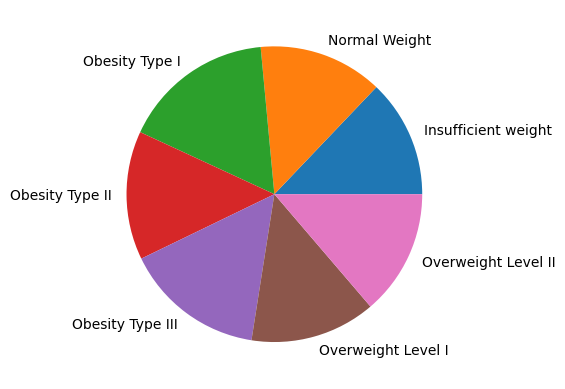

In [9]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

tmp = LabelEncoder()
y= tmp.fit_transform(df['NObeyesdad'])
class_labels = np.array(['Insufficient weight', 'Normal Weight', 'Obesity Type I', 'Obesity Type II', 'Obesity Type III', 'Overweight Level I', 'Overweight Level II'])
counts = np.bincount(y)
plt.pie(counts, labels = class_labels)
plt.show()

In [10]:
print(tmp.classes_)

['Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_I' 'Obesity_Type_II'
 'Obesity_Type_III' 'Overweight_Level_I' 'Overweight_Level_II']


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X = df.drop('NObeyesdad', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [12]:
X_df = X.copy()

One hot encode, scale 

In [13]:
from sklearn.preprocessing import OneHotEncoder
#there are other numeric attributes, but they are discrete, not continuous 
#age, height, weight, NCP (num of meals per day), CH20 (how much water you drink daily), and FAF (how ofetn exercise) are the continuous numeric columns
#there are other numeric attributes, but they are discrete, not continuous 
scaler = StandardScaler()
cont_indices = [0, 2, 3, 7, 10, 12]
categorical_index = [i for i in range(X.shape[1]) if i not in cont_indices]
print("Number of columns in X:", X.shape[1])  # Ensure the number of columns in X is as expected
print("Continuous column indices:", cont_indices)
X_df = X.copy()
X = X.to_numpy()
X_scale = scaler.fit_transform(X[:, cont_indices])
print(f'X_scale size {X_scale.shape}')
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown="ignore")
X_encoded = encoder.fit_transform(X[:, categorical_index])
X = np.hstack([X_scale, X_encoded])

#split for validation
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.20, random_state=1)
print(X.shape)


Number of columns in X: 16
Continuous column indices: [0, 2, 3, 7, 10, 12]
X_scale size (2111, 6)
(2111, 1958)


At the end of preprocessing, the categorical variables are one hot encoded, the continuous variables are scaled, the target variable was integer encoded. This dataset is used for classification because the target variable is a categorical variable. The other attributes in the data set will be used to classify the tuple by one of the labels (classes of the target variable). These include 'Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_I' 'Obesity_Type_II', 'Obesity_Type_III' 'Overweight_Level_I' 'Overweight_Level_II'.

The business case for this classification task is discussed later in the document. 

UPDATE 
i later had to repreprocess the data to do column crossing and embedding instead of one hot encoding, but i will continue to use this version of the preprocessed data for the rest of the first section of the lab (like the validation accuracy/test accuracy curve). 

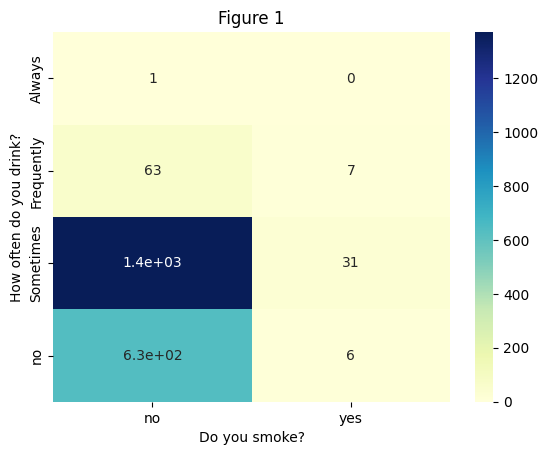

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
contingency_table = pd.crosstab(df['CALC'], df['SMOKE'])
sns.heatmap(contingency_table, annot=True, cmap="YlGnBu")
plt.xlabel('Do you smoke?')
plt.ylabel('How often do you drink?')
plt.title('Figure 1')
plt.show()

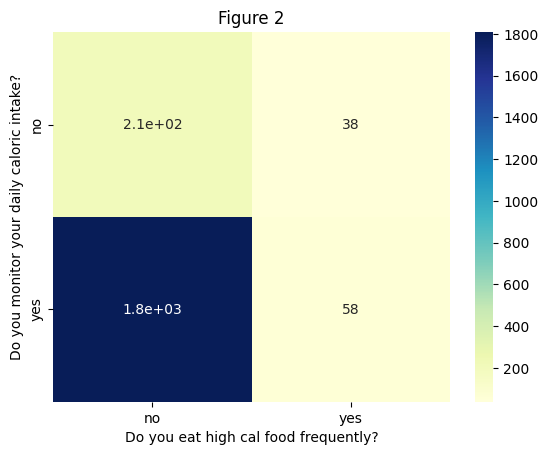

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
contingency_table = pd.crosstab(df['FAVC'], df['SCC'])
sns.heatmap(contingency_table, annot=True, cmap="YlGnBu")
plt.xlabel('Do you eat high cal food frequently?')
plt.ylabel('Do you monitor your daily caloric intake?')
plt.title('Figure 2')
plt.show()

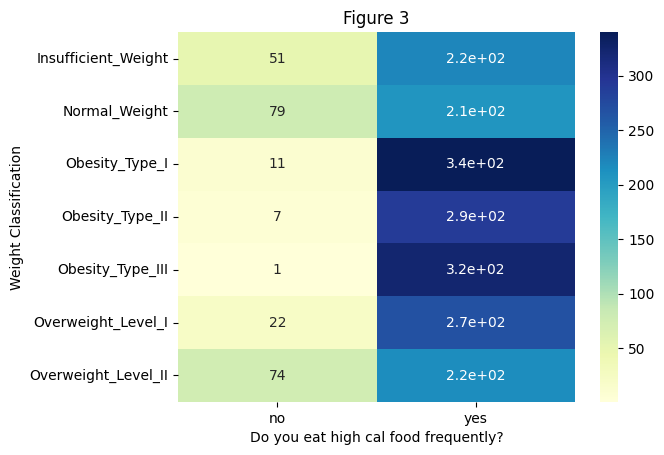

In [16]:
contingency_table = pd.crosstab(df['NObeyesdad'], df['FAVC'])
sns.heatmap(contingency_table, annot=True, cmap="YlGnBu")
plt.xlabel('Do you eat high cal food frequently?')
plt.ylabel('Weight Classification')
plt.title('Figure 3')
plt.show()

https://developers.google.com/machine-learning/crash-course/categorical-data/feature-crosses

Try not to cross two sparse features, this would create a new sparser feature than the original elements 

I would recommend crossing SMOKE (Binary, do you smoke?) and CALC (How often do you drink alcohol with answer options including no, sometimes, frequently, always). Each of these features has a small number of classes, which will make computations easy. They are also pretty correlated. As you can see by the heatmap above (Figure 1), If a person does not smoke, it is highly likely that they either dont drink, or that they only drink sometimes. This combination captures the interaction between lifestyle patterns (smoking and drinking) that could be valuable in predicting health characteristics, like if a person is obese.


I would also recommend crossing FAVC (Binary question:Do you eat high caloric food frequently? ) and SCC (Binary question, do you monitor the calories you eat daily?). Each is a binary question, meaning they will each have a yes or no answer, which makes the crossed feature simple. They also have a correlation. As you can see above, if a person does not eat high calorie food frequently, it is likely that they also monitor their caloric intake. This captures the interaction between a person being conscious of their diet/caloric intake, the health consequences associated with a poor diet (like obesity). If a person is conscious about their health in a way that causes them to not eat high calorie foods, it is likely that they are conscious of/monitor their daily calorie intake. These two factors logically influence eachother, so it makes sense to combine them. 


If a person eats high caloric food frequently (FAVC) and has a family history of obesity (family_history_with_overweight), it greatly influences the odds that the person is obese, which is the classification task at hand. This is why it may be beneficial to combine family_history_with_overweight and FAVC. In Figure 2, you can also see a correlation between the variables. If a person has a family history of obesity, it is more likely that they eat high calorie food frequently. People often adpot the lifestyle habits that they observed growing up. If a person's family eats high calorie food freuqently while they are a child, it is likely that they will have similar dietary habits in adulthood, and possibly similar health outcomes(Figure 3). 



This model classifies a person by their obesity level based on attributes like gender, age, their lifestyle choices (if they drink/smoke or are sedintary), their diet, etc. In a business scenario, this model could be used by doctors offices (general practitioners/weight loss specialists, or even online weight loss programs like Weight Watchers) to predict if a person is at risk for being obese based on their attributes, and recommend lifestyle changes accordingly.

 Obesity can lead to serious health conseuqences, like heart disease, cancer, and type 2 diabetes, all of which can be fatal. If a person has attributes that classify them as obese and the model fails to catch it, it could prevent a person from getting the intervention that they need to preserve their health. However, if the model misclassifies a person as obese when they are not, the recommended lifestyle changes wouldn't have a negative impact on the person.
 
  That being said false negatives have more serious implications than false positives. Because of this, we should use the recall metric. The recall metric measures the number of false negatives (the higher the recall, the lower the number of false neg), so we can be sure that our model is performing properly for the business application that we have in mind. 


#https://stackoverflow.com/questions/34731421/whats-the-difference-between-kfold-and-shufflesplit-cv#:~:text=KFold%20will%20divide%20your%20data,set%20and%20a%20test%20set.
use stratified for unbalanced


Based on the graph above the the figures above, we see that the data is realatively balanced. there is a relatively equal number of each class of the target variable in the data set. Even still, I will use stratified K-Fold to split the data. This will ensure that the folds maintain the original distribution of classes in the data to make sure that all of the classes are represented correctly.

The difference between kfold and shufflesplit is that kfold divides the data into a specific number of folds (each of which is a subset of the dataset) and shufflesplit randomly takes samples from your whole dataset to make a train and test set at each iteration. With shufflesplit, the test sets can overlap, where in kfold, they cant. To prevent overlap and any bias, I will use the kfold method. This also ensures that each data point will be used for testing (which is especially important because the dataset is small), whereas in shufflesplit, it is possible that a datapoint will not be used for testing at all. The dataset is also on the smaller side with 2111 samples, so kfold won't be too computationally expensive and can be used. 


Stratified kfold is an appropriate mirroring how the model would be used in a real world situation becuase it preserves the class distribution of the target variable. If this model was used in a medical office, the input data would be representative of the community that attends the office. The preservation of the class distribution with stratified kfold ensures that we are testing and training the model on data that mirrors the distributions of real world data, helping to simulate this scenario. If the classes were imbalanced due to random splits, it could lead to the model being biased. Regular kfold could also lead to a class imbalance problem that would skew the results

In [17]:
#have to split the data into testing and training before one hot encoding, normalizing, dimensionality reduction etc to prevent dats snooping
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Initialize stratified k-fold

pipe_rf = Pipeline([
                    ('pca', PCA(n_components=30,random_state=1)),
                    ('clf', RandomForestClassifier( random_state=1))])
# List to hold accuracy scores

kfold_for_validation = StratifiedKFold(n_splits=10).split(X_train1, y_train1)

scores = []
for k, (train, test) in enumerate(kfold_for_validation):
    pipe_rf.fit(X_train1[train], y_train1[train])
    score = pipe_rf.score(X_train1[test], y_train1[test])
    scores.append(score)
    print('Fold: %s, Acc: %.3f' % (k+1, score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Acc: 0.858
Fold: 2, Acc: 0.876
Fold: 3, Acc: 0.899
Fold: 4, Acc: 0.852
Fold: 5, Acc: 0.870
Fold: 6, Acc: 0.852
Fold: 7, Acc: 0.876
Fold: 8, Acc: 0.870
Fold: 9, Acc: 0.869
Fold: 10, Acc: 0.863

CV accuracy: 0.868 +/- 0.013


In [18]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_rf,
                         X=X_train1,
                         y=y_train1,
                         cv=10,
                         n_jobs=-1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.85798817 0.87573964 0.89940828 0.85207101 0.86982249 0.85207101
 0.87573964 0.86982249 0.86904762 0.86309524]
CV accuracy: 0.868 +/- 0.013


In [19]:
def plot_filled(train_scores,test_scores,train_x_axis, xlabel=''):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_x_axis, train_mean,
             color='blue', marker='o',
             markersize=5, label='training accuracy')

    plt.fill_between(train_x_axis,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_x_axis, test_mean,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label='validation accuracy')

    plt.fill_between(train_x_axis,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='green')

    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.tight_layout()

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores =learning_curve(estimator=pipe_rf,
                                                       X=X_train1,
                                                       y=y_train1,
                                                       train_sizes=np.linspace(0.1, 1.0, 10),
                                                       cv=5,
                                                       n_jobs=-1)

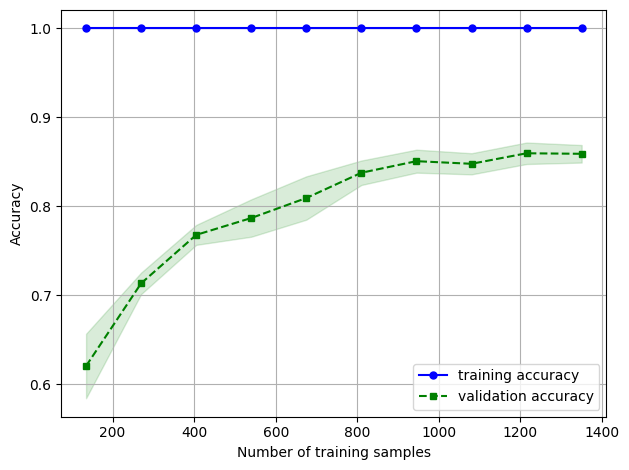

In [21]:
plot_filled(train_scores, test_scores, train_sizes, xlabel='Number of training samples')

Shows that it is overlearned

In [22]:
from sklearn.model_selection import validation_curve


param_name = 'clf__max_depth'
param_range = [5, 10, 15, 20]
train_scores, test_scores = validation_curve(
                estimator=pipe_rf, 
                X=X_train1, 
                y=y_train1, 
                param_name=param_name,
                param_range=param_range,
                cv=5,n_jobs=-1)

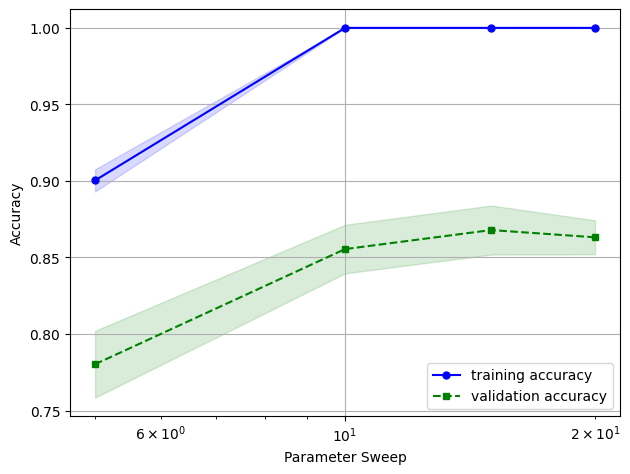

In [23]:
plot_filled(train_scores, test_scores, param_range, xlabel='Parameter Sweep')
plt.xscale('log')
plt.show()

Additional analysis stuff:


The blue line represents the mean training accuracy across the cross validation for each of the values of max depth (the max depth of each tree). There is supposed to be a blue shading around it that represents 1 standard deviation from the mean. The high/stable training accuracy across folds that we see with the horizonal line at 1 indicates that the model fits the training data well.

The green line represents the mean validation accuracy across all folds for each max depth param. The shaded area shows the variability in the validation accuracy. The green line is lower than the blue line, which may indicate overfitting. As far as parameter, I will choose 15, since that is where validation accuracy seems stable

The overfitting we see in this model relates to the analysis that we will do on our different wide and deep models below. We analysize the validation and training loss of those models on models with different depths, and look at the graph for signs of overfitting, like we see here. 

MODELING

In [24]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from sklearn import metrics as mt
#using venv, caused error with distutils, so added this line
import setuptools.dist
import tensorflow as tf
from tensorflow import keras
import sys

print(tf.__version__)
print(keras.__version__)
print(sys.version)

2.18.0
3.6.0
3.12.6 (v3.12.6:a4a2d2b0d85, Sep  6 2024, 16:08:03) [Clang 13.0.0 (clang-1300.0.29.30)]


In [25]:
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Embedding, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers

In [26]:
print(X.shape)
print(y.shape)
# print(y)


(2111, 1958)
(2111,)


Model Deep and Wide 1
    This model has 3 deep layers and one wide layer

Here i redo the preprocessing to do the categorical variable crossing and embedding.

 I decided to cross FAVC (Do you eat high caloric food frequently) and SCC (do you monitor your calroies daily) and CALC (how often do you drink alcohol) and SMOKE (do you smoke) because i believe that these variables have the highest correlation with eachother. The combination of drinking and smoking provides insight into the lifestyle habits that a person has, especially ones that can negatively impact one's health. This relationship can play a key factor in predicting a person's weight category, by showing how they prioritize their health. FAVC and SCC also have a very prominent relationship with eachother (as discussed above) and provide valuable information about a person's diet, which is a known valuable predictor for weight. 

I choose not to cross FAVC and family history of obesity because i believe that family history of obesity is a strong predictor of obesity on its own, and I think that crossing FAVC and SCC captures a more significant pattern in relation to the classification task. It is possible to cross all three of these variables, but choosing not to cross all three prevents creating overly sparse features and simplifies the training of the model. 

In [27]:
cross_columns = [
                 ['FAVC','SCC'],
                 ['CALC','SMOKE']
]
continuous_columns = ['Age', 'Height', 'Weight', 'NCP', 'CH2O', 'FAF']
cross_col_df_names = []
crossed_features = []

#these variables store the indices of each category in the final X numpy array so that i can access them later
crossed_feature_indices = []  
categorical_feature_indices = []  
numeric_feature_indices = []  


all_columns = X_df.columns.tolist()
crossed_flattened = [col for pair in cross_columns for col in pair]  # Flatten cross_columns
other_categorical_cols = [col for col in all_columns if col not in crossed_flattened + continuous_columns] #names of categorical columns that arent crossed

for cols_list in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()
    X_crossed = X_df[cols_list].apply(lambda x: '_'.join(x.astype(str)), axis=1)

    #get a name for the crossed column
    cross_col_name = '_'.join(cols_list)
    enc = LabelEncoder()
    X_crossed_encoded = enc.fit_transform(X_crossed).reshape(-1, 1)  #reshape to make sure it's 2D

    #keep track of the crossed features and the names of the resulting columns 
    crossed_features.append(X_crossed_encoded)
    cross_col_df_names.append(cross_col_name)

    #find the indices for the crossed feature indices 
    start_idx = len(numeric_feature_indices) + sum(len(f) for f in crossed_features[:-1])
    end_idx = start_idx + X_crossed_encoded.shape[1] - 1
    crossed_feature_indices.append((start_idx, end_idx))
#stack all od the crossed features together
crossed_features = np.hstack(crossed_features)

#encode the categorical fetaures that are not crossed as ints, they will later be imbeded 
encoded_categorical_features = []
for col in other_categorical_cols:
    enc = LabelEncoder()
    X_encoded = enc.fit_transform(X_df[col]).reshape(-1, 1)  
    encoded_categorical_features.append(X_encoded)
    idx = len(numeric_feature_indices) + crossed_features.shape[1] + len(encoded_categorical_features) - 1
    categorical_feature_indices.append(idx)

encoded_categorical_features = np.hstack(encoded_categorical_features)

#scale the continuous numeric features
scaler = StandardScaler()
print("Columns in X_df:", X_df.columns.tolist())
X_scale = scaler.fit_transform(X_df[continuous_columns])
numeric_feature_indices = list(range(X_scale.shape[1]))

#combine the crossed features, the not crossed categorical features, and the scaled cont numeric features
X = np.hstack([X_scale, crossed_features, encoded_categorical_features])

print(f'final shape {X.shape}')




Columns in X_df: ['Age', 'Gender', 'Height', 'Weight', 'CALC', 'FAVC', 'FCVC', 'NCP', 'SCC', 'SMOKE', 'CH2O', 'family_history_with_overweight', 'FAF', 'TUE', 'CAEC', 'MTRANS']
final shape (2111, 14)


In [28]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping



def create_wide_deep_model1(numeric_dim, crossed_dim, categorical_dim):
    # Inputs
    numeric_input = Input(shape=(numeric_dim,))
    crossed_input = Input(shape=(crossed_dim,))
    categorical_input = Input(shape=(categorical_dim,))

    # Wide part (combine numeric and crossed inputs)
    wide_input = layers.concatenate([numeric_input, crossed_input])
    wide_layer = Dense(32, activation='linear')(wide_input)

    # Deep part, input the categorical inputs
    deep_layer = Dense(128, activation='relu')(categorical_input)
    deep_layer = Dense(64, activation='relu')(deep_layer)
    deep_layer = Dense(32, activation='relu')(deep_layer)

    # Combine the wide and deep parts
    combined = layers.add([wide_layer, deep_layer])

    # Output layer
    output_layer = Dense(7, activation='softmax')(combined)

    # Create and compile the model
    model = Model(inputs=[numeric_input, crossed_input, categorical_input], outputs=output_layer)
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


In [29]:
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
# Define Stratified KFold with 10 splits
kfold_for_validation = StratifiedKFold(n_splits=10)

#lists to store metrics for the model 
auc_scores_model1 = []
val_losses = []
val_accuracies = []
rec_scores1 = []
# List to store the history at each
histories = []

# K-Fold Cross-Validation
for k, (train_idx, val_idx) in enumerate(kfold_for_validation.split(X,y)):
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]

#get scaled numeric X_train_fold 
    X_train_numeric = X_train_fold[:, numeric_feature_indices]
    X_train_crossed = np.hstack([
        X_train_fold[:, start:end+1] for start, end in crossed_feature_indices
    ])
    #gets categorical columns for x_train fold
    X_train_categorical = X_train_fold[:, categorical_feature_indices]

    #get numeric values for the validation set 
    X_val_numeric = X_val_fold[:, numeric_feature_indices]
    X_val_crossed = np.hstack([
        X_val_fold[:, start:end+1] for start, end in crossed_feature_indices
    ])
    #get categorical values for the validation set for the fold 
    X_val_categorical = X_val_fold[:, categorical_feature_indices]

    
    # Create a new Keras model for each fold 
    #we need the dimensions of every set of the data (like th numeric and categorical, and crossed)
    model_1 = create_wide_deep_model1(numeric_dim=X_train_numeric.shape[1],
        crossed_dim=X_train_crossed.shape[1],
        categorical_dim=X_train_categorical.shape[1])
    
    # Use EarlyStopping to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model on the current fold
    history = model_1.fit([X_train_numeric, X_train_crossed, X_train_categorical],
        y_train_fold,
        validation_data=(
            [X_val_numeric, X_val_crossed, X_val_categorical],
            y_val_fold
        ),
              epochs=50, 
              batch_size=32, 
              callbacks=[early_stopping], 
              verbose=0)
    histories.append(history)


    y_pred_probs = model_1.predict([X_val_numeric, X_val_crossed, X_val_categorical])
    y_pred = np.argmax(y_pred_probs, axis=1)

    #save the roc auc score for each fold for later
    auc_fold_model1 = roc_auc_score(y_val_fold, y_pred_probs, multi_class='ovr', average='macro')
    auc_scores_model1.append(auc_fold_model1)

    #calculate recall at each fold to evaluate performance 
    recall = recall_score(y_val_fold, y_pred, average='macro')
    rec_scores1.append(recall)

    #find loss and accuract of the validation data
    val_loss, val_accuracy = model_1.evaluate(
        [X_val_numeric, X_val_crossed, X_val_categorical],
        y_val_fold,
        verbose=0
    )
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Fold {k} - Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Recall: {recall:.4f}")

# Calculate average performance metrics across all folds
avg_rec = np.mean(rec_scores1)
avg_val_loss = np.mean(val_losses)
avg_val_accuracy = np.mean(val_accuracies)
print(f"Average Validation Loss: {avg_val_loss:.4f}, Average Validation Accuracy: {avg_val_accuracy:.4f}")
print("Average Recall Score: ", avg_rec)


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_1', 'keras_tensor_2']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Fold 0 - Validation Loss: 0.3737, Accuracy: 0.8538, Recall: 0.8513


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_10', 'keras_tensor_11', 'keras_tensor_12']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 1 - Validation Loss: 0.4518, Accuracy: 0.8436, Recall: 0.8380


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_20', 'keras_tensor_21', 'keras_tensor_22']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Fold 2 - Validation Loss: 0.2005, Accuracy: 0.9526, Recall: 0.9507


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_30', 'keras_tensor_31', 'keras_tensor_32']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 3 - Validation Loss: 0.1913, Accuracy: 0.9431, Recall: 0.9426


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_40', 'keras_tensor_41', 'keras_tensor_42']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 4 - Validation Loss: 0.2143, Accuracy: 0.9431, Recall: 0.9434


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_50', 'keras_tensor_51', 'keras_tensor_52']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Fold 5 - Validation Loss: 0.1870, Accuracy: 0.9526, Recall: 0.9516


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_60', 'keras_tensor_61', 'keras_tensor_62']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 6 - Validation Loss: 0.2363, Accuracy: 0.9431, Recall: 0.9409


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_70', 'keras_tensor_71', 'keras_tensor_72']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 7 - Validation Loss: 0.1571, Accuracy: 0.9526, Recall: 0.9499


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_80', 'keras_tensor_81', 'keras_tensor_82']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Fold 8 - Validation Loss: 0.1658, Accuracy: 0.9526, Recall: 0.9515


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_90', 'keras_tensor_91', 'keras_tensor_92']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Fold 9 - Validation Loss: 0.1608, Accuracy: 0.9526, Recall: 0.9512
Average Validation Loss: 0.2339, Average Validation Accuracy: 0.9290
Average Recall Score:  0.9271185109362449


Plot originial model

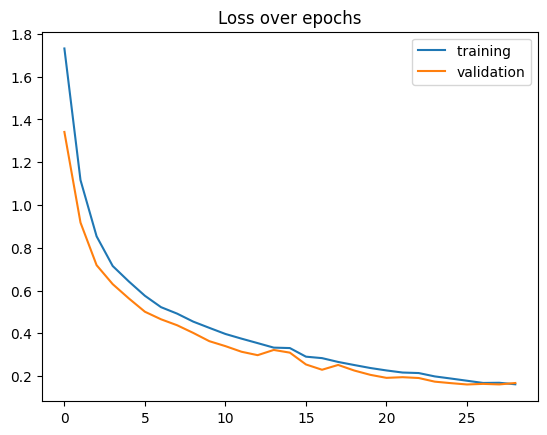

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],label='training ')
plt.plot(history.history['val_loss'],label='validation')
plt.title('Loss over epochs')
plt.legend()
plt.show()


https://developers.google.com/machine-learning/crash-course/linear-regression/gradient-descent#model_convergence_and_loss_curves


Loss is a metric that shows how wrong a model's predictions are. A downward slope of the loss curve means that the model is improving (it is making less wrong predictions) and the flattening of the curve shows that the model is converging. 

When you compare the loss curves of the training and validation data, you see a steep drop initially for both, then the curve beginning to flatten. This is normal and symbolizes that the model is training, improving, and converging. Since there isnt much of a gap between the training and validation curve, we can conclude that overfitting is not occurring in this model. 

I use the same embedding process for the following models as i did for model 1

Wide and Deep model 2
    This model uses two more deep layers

In [31]:
# Function to create Keras model
def create_wide_deep_model2(numeric_dim, crossed_dim, categorical_dim):
    # Input layer
    numeric_input = Input(shape=(numeric_dim,))
    crossed_input = Input(shape=(crossed_dim,))
    categorical_input = Input(shape=(categorical_dim,))
    
    wide_input = layers.concatenate([numeric_input, crossed_input])
    # Wide part (shallow model, might just be one dense layer)
    wide_layer = Dense(16, activation='linear')(wide_input)
    
    # Deep part (deeper neural network with more layers)
    deep_layer = Dense(512, activation='relu')(categorical_input)
    deep_layer = Dense(256, activation='relu')(deep_layer)
    deep_layer = Dense(128, activation='relu')(deep_layer)
    deep_layer = Dense(64, activation='relu')(deep_layer)
    deep_layer = Dense(32, activation='relu')(deep_layer)
    deep_layer = Dense(16, activation='relu')(deep_layer)
    
    # Combine the wide and deep parts (concatenate)
    combined = layers.add([wide_layer, deep_layer])

    #output
    output_layer = Dense(7, activation='softmax')(combined)
    
    # Create the model
    model = Model(inputs=[numeric_input, crossed_input, categorical_input], outputs=output_layer)
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [32]:
# Define Stratified KFold with 10 splits
kfold_for_validation = StratifiedKFold(n_splits=10)

# List to store validation metrics for each fold
val_losses = []
val_accuracies = []
rec_scores = []
# List to store the history at each
histories = []
auc_scores_model2 = []

# K-Fold Cross-Validation
for k, (train_idx, val_idx) in enumerate(kfold_for_validation.split(X,y)):
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]

    X_train_numeric = X_train_fold[:, numeric_feature_indices]
    X_train_crossed = np.hstack([
        X_train_fold[:, start:end+1] for start, end in crossed_feature_indices
    ])
    #gets categorical columns for x_train fold
    X_train_categorical = X_train_fold[:, categorical_feature_indices]

    #get numeric values for the validation set 
    X_val_numeric = X_val_fold[:, numeric_feature_indices]
    X_val_crossed = np.hstack([
        X_val_fold[:, start:end+1] for start, end in crossed_feature_indices
    ])
    #get categorical values for the validation set for the fold 
    X_val_categorical = X_val_fold[:, categorical_feature_indices]
    
    
    # Create a new Keras model for each fold 
    model_2 = create_wide_deep_model2(numeric_dim=X_train_numeric.shape[1],
        crossed_dim=X_train_crossed.shape[1],
        categorical_dim=X_train_categorical.shape[1])
    
    # Use EarlyStopping to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    print(y_val_fold.size)
    
    # Train the model on the current fold
    history = model_2.fit([X_train_numeric, X_train_crossed, X_train_categorical],
        y_train_fold,
        validation_data=(
            [X_val_numeric, X_val_crossed, X_val_categorical],
            y_val_fold),
              epochs=50, 
              batch_size=32, 
              callbacks=[early_stopping], 
              verbose=0)
    histories.append(history)

    y_pred_probs2 = model_2.predict([X_val_numeric, X_val_crossed, X_val_categorical])  # Predicted probabilities
    y_pred2 = np.argmax(y_pred_probs2, axis=1)  # Convert probabilities to class predictions

    auc_fold_model2 = roc_auc_score(y_val_fold, y_pred_probs2, multi_class='ovr', average='macro')
    auc_scores_model2.append(auc_fold_model2)
    recall = recall_score(y_val_fold, y_pred2, average='macro')
    rec_scores.append(recall)
    val_loss, val_accuracy = model_1.evaluate(
        [X_val_numeric, X_val_crossed, X_val_categorical],
        y_val_fold,
        verbose=0
    )
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Fold {k} - Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Recall: {recall:.4f}")

# Calculate average performance metrics across all folds
avg_rec = np.mean(rec_scores)
avg_val_loss = np.mean(val_losses)
avg_val_accuracy = np.mean(val_accuracies)
print(f"Average Validation Loss: {avg_val_loss:.4f}, Average Validation Accuracy: {avg_val_accuracy:.4f}")
print("Average Recall Score: ", avg_rec)


212


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_100', 'keras_tensor_101', 'keras_tensor_102']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Fold 0 - Validation Loss: 0.1743, Accuracy: 0.9481, Recall: 0.7057
211


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_113', 'keras_tensor_114', 'keras_tensor_115']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Fold 1 - Validation Loss: 0.2337, Accuracy: 0.9005, Recall: 0.7765
211


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_126', 'keras_tensor_127', 'keras_tensor_128']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Fold 2 - Validation Loss: 0.1654, Accuracy: 0.9573, Recall: 0.9327
211


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_139', 'keras_tensor_140', 'keras_tensor_141']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Fold 3 - Validation Loss: 0.1458, Accuracy: 0.9716, Recall: 0.8918
211


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_152', 'keras_tensor_153', 'keras_tensor_154']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Fold 4 - Validation Loss: 0.1583, Accuracy: 0.9621, Recall: 0.8188
211


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_165', 'keras_tensor_166', 'keras_tensor_167']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Fold 5 - Validation Loss: 0.1406, Accuracy: 0.9810, Recall: 0.8787
211


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_178', 'keras_tensor_179', 'keras_tensor_180']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Fold 6 - Validation Loss: 0.1469, Accuracy: 0.9668, Recall: 0.8783
211


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_191', 'keras_tensor_192', 'keras_tensor_193']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Fold 7 - Validation Loss: 0.1509, Accuracy: 0.9668, Recall: 0.9046
211


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_204', 'keras_tensor_205', 'keras_tensor_206']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Fold 8 - Validation Loss: 0.1267, Accuracy: 0.9716, Recall: 0.9264
211


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_217', 'keras_tensor_218', 'keras_tensor_219']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Fold 9 - Validation Loss: 0.1608, Accuracy: 0.9526, Recall: 0.9208
Average Validation Loss: 0.1603, Average Validation Accuracy: 0.9578
Average Recall Score:  0.8634382648914668


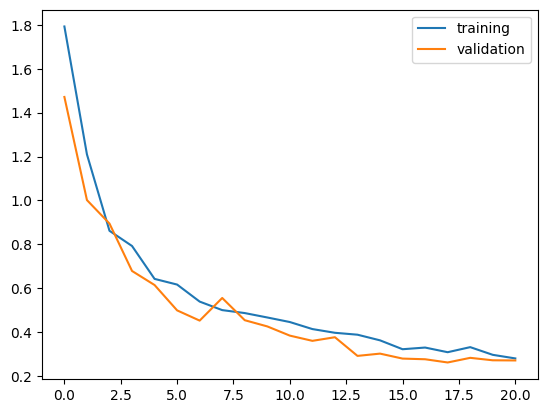

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()
plt.show()


Model 2 is deeper than model one. It has 6 deep layers instead of 3. 

We can see that the validation loss curve is kind of spiky, which indicates that the loss values fluctuate across epochs. It is possible that this is due to noise or random chance, especially  since the validation set only contains 212 samples, which is relatively small and could explain this fluctuation. 

The recall score is also significantly worse in this model than it was in the previous (.84 vs .92). The additional deep layers (compared to our first wide and deep model) could also cause the validation loss curve to fluctuate more because the increased depth may be doing a worse job at generalizing. The model could be learning too many specific patterns in the data, which would lead to worse generalization of the overall patterns in the data, leading to worse performance. 

Wide and Deep model 3
    This model uses less deep layers

In [34]:
def create_wide_deep_model3(numeric_dim, crossed_dim, categorical_dim):
    # Input layer
    numeric_input = Input(shape=(numeric_dim,))
    crossed_input = Input(shape=(crossed_dim,))
    categorical_input = Input(shape=(categorical_dim,))

    # Wide part (concatenate numeric and crossed inputs)
    wide_input = layers.concatenate([numeric_input, crossed_input])
    wide_layer = Dense(16, activation='linear')(wide_input)
    
    # Deep part (deeper neural network with more layers)
    deep_layer = Dense(32, activation='relu')(categorical_input)
    deep_layer = Dense(16, activation='relu')(deep_layer)
    
    # Combine the wide and deep parts (concatenate)
    combined = layers.add([wide_layer, deep_layer])

    #output
    output_layer = Dense(7, activation='softmax')(combined)
    
    # Create the model
    model = Model(inputs=[numeric_input, crossed_input, categorical_input], outputs=output_layer)
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [35]:
# Define Stratified KFold with 10 splits
kfold_for_validation = StratifiedKFold(n_splits=10)

# List to store validation metrics for each fold
val_losses = []
val_accuracies = []
# List to store the history at each
histories = []
rec_scores3 = []

auc_scores_model3 = []

# K-Fold Cross-Validation
for k, (train_idx, val_idx) in enumerate(kfold_for_validation.split(X,y)):
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]


    X_train_numeric = X_train_fold[:, numeric_feature_indices]
    X_train_crossed = np.hstack([
        X_train_fold[:, start:end+1] for start, end in crossed_feature_indices
    ])
    #gets categorical columns for x_train fold
    X_train_categorical = X_train_fold[:, categorical_feature_indices]

    #get numeric values for the validation set 
    X_val_numeric = X_val_fold[:, numeric_feature_indices]
    X_val_crossed = np.hstack([
        X_val_fold[:, start:end+1] for start, end in crossed_feature_indices
    ])
    #get categorical values for the validation set for the fold 
    X_val_categorical = X_val_fold[:, categorical_feature_indices]

    
    # Create a new Keras model for each fold 
    model_3 = create_wide_deep_model3(numeric_dim=X_train_numeric.shape[1],
        crossed_dim=X_train_crossed.shape[1],
        categorical_dim=X_train_categorical.shape[1])
    
    # Use EarlyStopping to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model on the current fold
    history = model_3.fit([X_train_numeric, X_train_crossed, X_train_categorical],
        y_train_fold,
        validation_data=(
            [X_val_numeric, X_val_crossed, X_val_categorical],
            y_val_fold
        ),
              epochs=50, 
              batch_size=32, 
              callbacks=[early_stopping], 
              verbose=0)
    histories.append(history)

    
    y_pred_probs3 = model_3.predict([X_val_numeric, X_val_crossed, X_val_categorical])
    y_pred3 = np.argmax(y_pred_probs3, axis=1)

    auc_fold_model3 = roc_auc_score(y_val_fold, y_pred_probs3, multi_class='ovr', average='macro')
    auc_scores_model3.append(auc_fold_model3)

    recall = recall_score(y_val_fold, y_pred3, average='macro')
    rec_scores3.append(recall)

    val_loss, val_accuracy = model_3.evaluate(
        [X_val_numeric, X_val_crossed, X_val_categorical],
        y_val_fold,
        verbose=0
    )
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Fold {k} - Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Recall: {recall:.4f}")

# Calculate average performance metrics across all folds
avg_rec = np.mean(rec_scores)
avg_val_loss = np.mean(val_losses)
avg_val_accuracy = np.mean(val_accuracies)
print(f"Average Validation Loss: {avg_val_loss:.4f}, Average Validation Accuracy: {avg_val_accuracy:.4f}")
print("Average Recall Score: ", avg_rec)

/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_230', 'keras_tensor_231', 'keras_tensor_232']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 0 - Validation Loss: 0.3630, Accuracy: 0.8443, Recall: 0.8443


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_239', 'keras_tensor_240', 'keras_tensor_241']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Fold 1 - Validation Loss: 0.4197, Accuracy: 0.8436, Recall: 0.8392


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_248', 'keras_tensor_249', 'keras_tensor_250']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 2 - Validation Loss: 0.2175, Accuracy: 0.9431, Recall: 0.9409


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_257', 'keras_tensor_258', 'keras_tensor_259']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Fold 3 - Validation Loss: 0.1856, Accuracy: 0.9573, Recall: 0.9567


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_266', 'keras_tensor_267', 'keras_tensor_268']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Fold 4 - Validation Loss: 0.2466, Accuracy: 0.9147, Recall: 0.9130


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_275', 'keras_tensor_276', 'keras_tensor_277']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 5 - Validation Loss: 0.2005, Accuracy: 0.9431, Recall: 0.9417


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_284', 'keras_tensor_285', 'keras_tensor_286']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 6 - Validation Loss: 0.1692, Accuracy: 0.9763, Recall: 0.9754


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_293', 'keras_tensor_294', 'keras_tensor_295']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 7 - Validation Loss: 0.2045, Accuracy: 0.9242, Recall: 0.9224


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_302', 'keras_tensor_303', 'keras_tensor_304']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 8 - Validation Loss: 0.1537, Accuracy: 0.9716, Recall: 0.9706


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_311', 'keras_tensor_312', 'keras_tensor_313']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 9 - Validation Loss: 0.1810, Accuracy: 0.9479, Recall: 0.9464
Average Validation Loss: 0.2341, Average Validation Accuracy: 0.9266
Average Recall Score:  0.8634382648914668


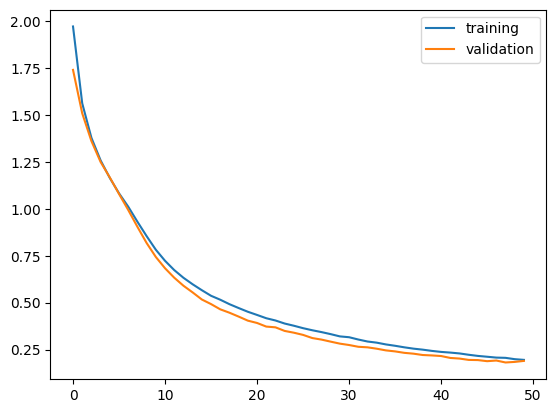

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()
plt.show()


Model 3 only uses 2 deep layers, which is less than our previous two models. 

While the average recall of Model 3 is similar to that of Model 1, the loss curves are much smoother, both for training and validation data. Deeper networks often have more complex optimization landscapes, meaning there may be more local minimums/saddle points, which would cause more variation across epochs. 

The improved performance of this model over the previous ones (especially model 2) indicates that the smaller number of deep layers is doing a better job of generalizing, which causes less fluctuation in loss over epochs. This makes sense since because the classification task is relatively simple. The attributes in the data set contain very valuable predictors for the task and there is a limited number of classes in the target variable. (EX: eating high calorie food and having a family history of obesity are knwon predictors of obesity) Additional deep layers, like in Model 2, are unnecessary and can cause the model to capture obscure/trivial patterns in the data. 

No Wide, Only Deep model

This is the same as the original model but without any wide layers

In [37]:
def create_deep_model(numeric_dim, crossed_dim, categorical_dim):
    # Input layer
    numeric_input = Input(shape=(numeric_dim,))
    crossed_input = Input(shape=(crossed_dim,))
    categorical_input = Input(shape=(categorical_dim,))

    numeric_dense = Dense(64, activation='relu')(numeric_input)
    crossed_dense = Dense(64, activation='relu')(crossed_input)
    categorical_dense = Dense(64, activation='relu')(categorical_input)

    combined = Concatenate()([numeric_dense, crossed_dense, categorical_dense])

    deep_layer = Dense(128, activation='relu')(combined)
    deep_layer = Dense(64, activation='relu')(deep_layer)
    deep_layer = Dense(32, activation='relu')(deep_layer)
    
    # Combine the wide and deep parts (concatenate)
    # combined = Dense(16, activation='relu')(wide_layer)  # Can also combine here
    output_layer = Dense(7, activation='softmax')(deep_layer)  # Output layer
    
    # Create the model
    model = Model(inputs=[numeric_input, crossed_input, categorical_input], outputs=output_layer)
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [38]:
# Define Stratified KFold with 10 splits
kfold_for_validation = StratifiedKFold(n_splits=10)


# List to store validation metrics for each fold
val_losses = []
val_accuracies = []
# List to store the history at each
histories = []
auc_scores_deep = []
rec_scores_deep = []

# K-Fold Cross-Validation
for k, (train_idx, val_idx) in enumerate(kfold_for_validation.split(X,y)):
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]

    X_train_numeric = X_train_fold[:, numeric_feature_indices]
    X_train_crossed = np.hstack([
        X_train_fold[:, start:end+1] for start, end in crossed_feature_indices
    ])
    #gets categorical columns for x_train fold
    X_train_categorical = X_train_fold[:, categorical_feature_indices]

    #get numeric values for the validation set 
    X_val_numeric = X_val_fold[:, numeric_feature_indices]
    X_val_crossed = np.hstack([
        X_val_fold[:, start:end+1] for start, end in crossed_feature_indices
    ])
    #get categorical values for the validation set for the fold 
    X_val_categorical = X_val_fold[:, categorical_feature_indices]
    


    # Create a new Keras model for each fold 
    model_noWide = create_deep_model(numeric_dim=X_train_numeric.shape[1],
        crossed_dim=X_train_crossed.shape[1],
        categorical_dim=X_train_categorical.shape[1])
    
    # Use EarlyStopping to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model on the current fold
    history = model_noWide.fit([X_train_numeric, X_train_crossed, X_train_categorical],
        y_train_fold,
        validation_data=(
            [X_val_numeric, X_val_crossed, X_val_categorical],
            y_val_fold
        ),
              epochs=50, 
              batch_size=32, 
              callbacks=[early_stopping], 
              verbose=0)
    histories.append(history)

    y_pred_probs_deep = model_noWide.predict([X_val_numeric, X_val_crossed, X_val_categorical])
    y_pred_deep = np.argmax(y_pred_probs_deep, axis=1)

    auc_fold_model_deep = roc_auc_score(y_val_fold, y_pred_probs_deep, multi_class='ovr', average='macro')
    auc_scores_deep.append(auc_fold_model_deep)

    recall = recall_score(y_val_fold, y_pred_deep, average='macro')
    rec_scores_deep.append(recall)
    
    val_loss, val_accuracy = model_noWide.evaluate(
        [X_val_numeric, X_val_crossed, X_val_categorical],
        y_val_fold,
        verbose=0
    )
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Fold {k} - Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Recall: {recall:.4f}")

# Calculate average performance metrics across all folds
avg_rec = np.mean(rec_scores)
avg_val_loss = np.mean(val_losses)
avg_val_accuracy = np.mean(val_accuracies)
print("Average Recall Score: ", avg_rec)
print(f"Average Validation Loss: {avg_val_loss:.4f}, Average Validation Accuracy: {avg_val_accuracy:.4f}")

/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_320', 'keras_tensor_321', 'keras_tensor_322']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Fold 0 - Validation Loss: 0.2340, Accuracy: 0.9057, Recall: 0.9010


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_331', 'keras_tensor_332', 'keras_tensor_333']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Fold 1 - Validation Loss: 0.2516, Accuracy: 0.9052, Recall: 0.9020


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_342', 'keras_tensor_343', 'keras_tensor_344']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Fold 2 - Validation Loss: 0.1547, Accuracy: 0.9479, Recall: 0.9459


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_353', 'keras_tensor_354', 'keras_tensor_355']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Fold 3 - Validation Loss: 0.1021, Accuracy: 0.9668, Recall: 0.9652


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_364', 'keras_tensor_365', 'keras_tensor_366']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Fold 4 - Validation Loss: 0.1217, Accuracy: 0.9573, Recall: 0.9574


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_375', 'keras_tensor_376', 'keras_tensor_377']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Fold 5 - Validation Loss: 0.0642, Accuracy: 0.9810, Recall: 0.9811


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_386', 'keras_tensor_387', 'keras_tensor_388']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Fold 6 - Validation Loss: 0.1012, Accuracy: 0.9763, Recall: 0.9762


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_397', 'keras_tensor_398', 'keras_tensor_399']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Fold 7 - Validation Loss: 0.0914, Accuracy: 0.9668, Recall: 0.9652


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_408', 'keras_tensor_409', 'keras_tensor_410']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Fold 8 - Validation Loss: 0.0538, Accuracy: 0.9858, Recall: 0.9847


/Users/elichesnut/Documents/GitHub/MLLab5-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_419', 'keras_tensor_420', 'keras_tensor_421']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Fold 9 - Validation Loss: 0.1166, Accuracy: 0.9668, Recall: 0.9657
Average Recall Score:  0.8634382648914668
Average Validation Loss: 0.1291, Average Validation Accuracy: 0.9560


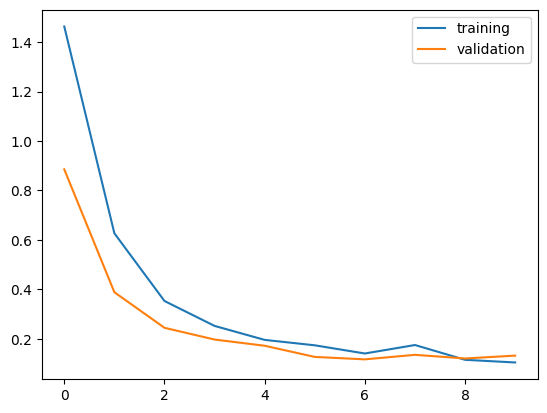

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()
plt.show()


https://stats.stackexchange.com/questions/222883/why-are-neural-networks-becoming-deeper-but-not-wider/223637#223637


The deep model has the highest recall score. This is probably because deep networks, generally speaking, do a better job at generalizing than wide networks (which use memorization). Like i said before, since the classification task is pretty simple, a simple model works well. 


In [40]:
from scipy import stats
t_stat, p_value = stats.ttest_rel(rec_scores3, rec_scores)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

T-statistic: 4.8338
P-value: 0.0009


(Description of the stat test i choose below)

Our null hypothesis is that the model 3's recall scores and model 1's recall scores are not statistically different. 

Based on a standard significance value of .05, we are able to reject the null hypotheses (p = .0076). This allows us to conclude that the the recall scores for model 1 and model 3 are statistically different. More specifically, we can say that the recall score for model 3 is higher than the recall score for model 1. 

I am not doing a statistic test to compare the recall for model two because the average recall is significantly lower than the recall scores of model 1 and 3. If model one and 3 are statistically different, then model 2 is also statistically different from model 3, so we can conclude that model 3 is the best performing. 

Out of our wide and deep models, model3 with 2 deep layers had the best performance, seeing as it had the highest accuracy and recall scores. 

In [41]:
from sklearn.metrics import roc_auc_score



auc_wide_deep = roc_auc_score(y_val_fold, y_pred_probs3, multi_class='ovr', average='macro')
auc_deep = roc_auc_score(y_val_fold, y_pred_probs_deep, multi_class='ovr', average='macro')

print(f"Wide & Deep Model AUC: {auc_wide_deep:.4f}")
print(f"Deep Model AUC: {auc_deep:.4f}")


Wide & Deep Model AUC: 0.9982
Deep Model AUC: 0.9973


Use pval to see if the difference ROC AUC scores is statistically significant enough to indicate a difference in model performance. 

In [42]:
from scipy import stats

# Suppose auc_wide_deep and auc_mlp are arrays of AUC scores for each fold
t_stat, p_value = stats.ttest_rel(auc_scores_model3, auc_scores_deep)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")


T-statistic: -2.3448
P-value: 0.0437


The AUC score will range between 0 and 1 depending on the performance of the model. The ROC AUC score represents the area under the ROC Curve, which plots the true positive rate over the false positive rate. 

The  closer the AUC score is to 1.0, the better the model is performing. That being said, both our wide and deep model and the just deep model are performing very well, both having AUC scores over .99. However, the AUC score we get of the deep model has a slightly slightly better (.9993), although this difference may not be statistically significant. 

Because this is multiclass classification, we use multi_class = ovr, which means that the ROC AUC will be calculated with the one versus rest approach, meaning each class is considered as a seperate binary classification task and the AUC score will be computed for each class. The average AUC score for each class will then be calculated. Because of the ovr parameter, we will get the average AUC scores where each class is weighted equally(macro param assigns equal weights). This works nicely because the classes of the target variable are pretty evenly distributed.

I am using p-value to determine if the difference in performance of the two models is statstically significant. This means that it tells us if the models performance is actually different, or if the performance of one is only better than the other due to the choice of data points used for testing/training (or some other random factor), and that if the test was repeated on a different subset of data, it is possible that the other model would have a better performance. 

Our null hypothesis is that the model's AUC scores are not statistically different. I choose a significance value of .05, which is the standard choice. Because the p-value is lower than the significance value (p = .0236), we reject the null hypothesis and conclude that there is sufficient evidence to conclude that AUC scores of the models are significantly different. 

This means that we can conclude that the only deep model has a better performance than the wide and deep model (model 3) based on the ROC AUC score, statistically speaking. 